In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [17]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 2))
fixed_data, _ = next(iter(test_loader))

In [18]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh, flatten=False):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [19]:
class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma

        self.fce = FullyConnected([784, 512, 128, latent_size*2], activation_fn=nn.ReLU, flatten=True)
        self.fcd = FullyConnected([latent_size, 128, 512, 784], activation_fn=nn.ReLU)
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
    
    def encode(self, x):
        h = self.fce(x)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h):
        flatten = torch.tanh(self.fcd(h))
        x = flatten.view(-1, 1, 28, 28)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        x = self.decode(h)
        return x
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size])
    
    def loss(self, output, target, size_average=True):
        KLD = self.mu**2 + self.logvar.exp() - 1 - self.logvar
        KLD = 0.5*KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
            self._loss = F.mse_loss(output, target, reduction='mean')
        else:
            self.KLD = KLD.sum()
            self._loss = F.mse_loss(output, target, reduction='sum')
        
        return self._loss + self.gamma*self.KLD

In [20]:
models = {'VAE10': Net(2, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [21]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [22]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()
    
    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                    test_reconstruction_loss[k], 
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        with torch.no_grad():
            ae_data = models[k](fixed_data).data.numpy()
            fixed_gen = models[k].decode(fixed_z).data.numpy()
            plot_mnist(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
            plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses VAE10: 0.9382
Train Epoch: 1 [10000/50000 (20%)]	Losses VAE10: 0.2731
Train Epoch: 1 [20000/50000 (40%)]	Losses VAE10: 0.2409
Train Epoch: 1 [30000/50000 (60%)]	Losses VAE10: 0.2061
Train Epoch: 1 [40000/50000 (80%)]	Losses VAE10: 0.2203
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE10: 0.2149


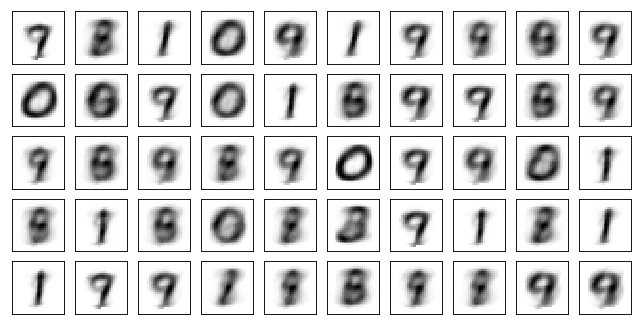

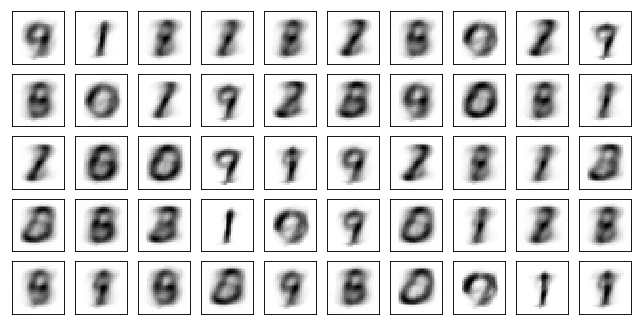

Test losses: VAE10: 0.2070/3.0029
Train Epoch: 2 [0/50000 (0%)]	Losses VAE10: 0.2003
Train Epoch: 2 [10000/50000 (20%)]	Losses VAE10: 0.2162
Train Epoch: 2 [20000/50000 (40%)]	Losses VAE10: 0.2176
Train Epoch: 2 [30000/50000 (60%)]	Losses VAE10: 0.2043
Train Epoch: 2 [40000/50000 (80%)]	Losses VAE10: 0.2122
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE10: 0.2002


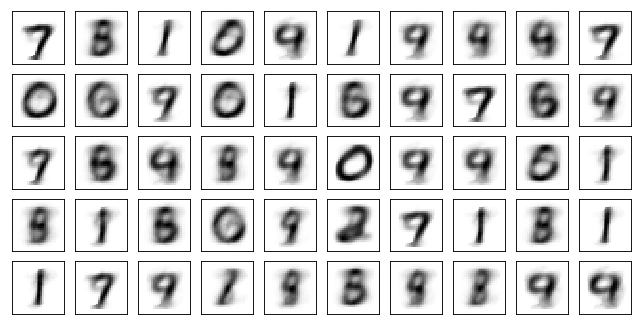

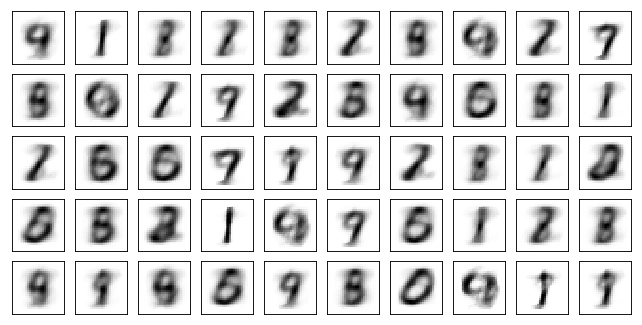

Test losses: VAE10: 0.1940/3.3974
Train Epoch: 3 [0/50000 (0%)]	Losses VAE10: 0.2135
Train Epoch: 3 [10000/50000 (20%)]	Losses VAE10: 0.1793
Train Epoch: 3 [20000/50000 (40%)]	Losses VAE10: 0.1975
Train Epoch: 3 [30000/50000 (60%)]	Losses VAE10: 0.1888
Train Epoch: 3 [40000/50000 (80%)]	Losses VAE10: 0.2001
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE10: 0.1973


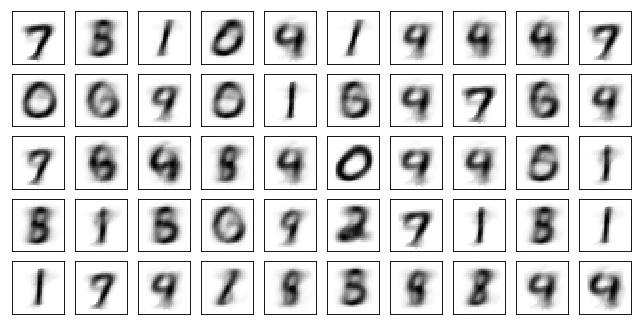

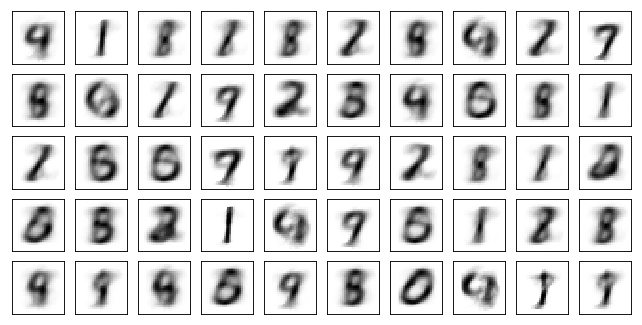

Test losses: VAE10: 0.1887/3.4802
Train Epoch: 4 [0/50000 (0%)]	Losses VAE10: 0.1811
Train Epoch: 4 [10000/50000 (20%)]	Losses VAE10: 0.1778
Train Epoch: 4 [20000/50000 (40%)]	Losses VAE10: 0.1796
Train Epoch: 4 [30000/50000 (60%)]	Losses VAE10: 0.1824
Train Epoch: 4 [40000/50000 (80%)]	Losses VAE10: 0.1972
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE10: 0.1856


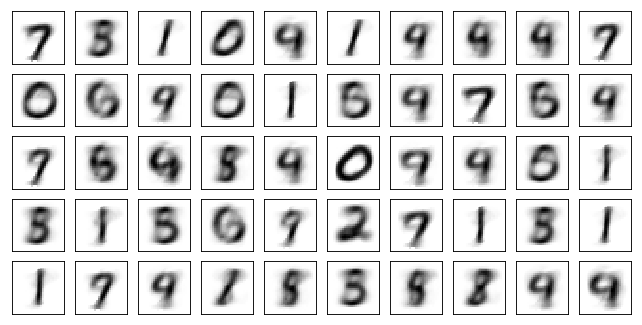

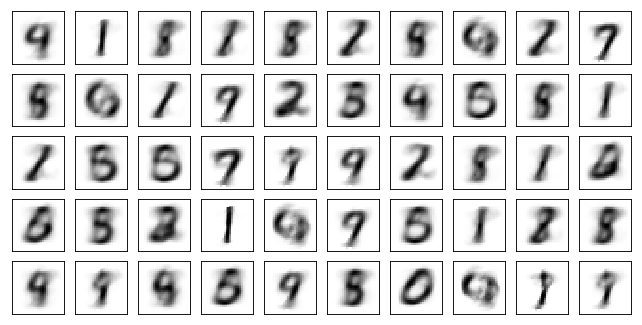

Test losses: VAE10: 0.1843/3.6615
Train Epoch: 5 [0/50000 (0%)]	Losses VAE10: 0.1750
Train Epoch: 5 [10000/50000 (20%)]	Losses VAE10: 0.1994
Train Epoch: 5 [20000/50000 (40%)]	Losses VAE10: 0.1865
Train Epoch: 5 [30000/50000 (60%)]	Losses VAE10: 0.1899
Train Epoch: 5 [40000/50000 (80%)]	Losses VAE10: 0.1828
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE10: 0.1990


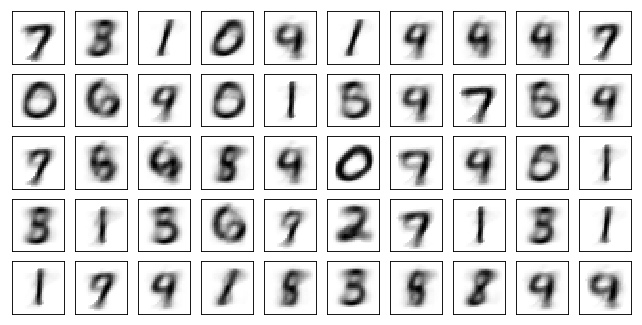

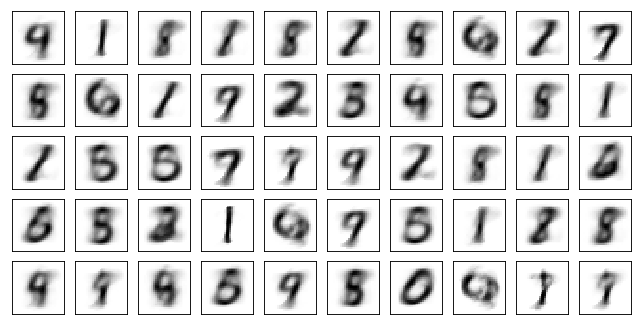

Test losses: VAE10: 0.1809/3.8082
Train Epoch: 6 [0/50000 (0%)]	Losses VAE10: 0.1830
Train Epoch: 6 [10000/50000 (20%)]	Losses VAE10: 0.1973
Train Epoch: 6 [20000/50000 (40%)]	Losses VAE10: 0.1892
Train Epoch: 6 [30000/50000 (60%)]	Losses VAE10: 0.1852
Train Epoch: 6 [40000/50000 (80%)]	Losses VAE10: 0.1891
Train Epoch: 6 [50000/50000 (100%)]	Losses VAE10: 0.1765


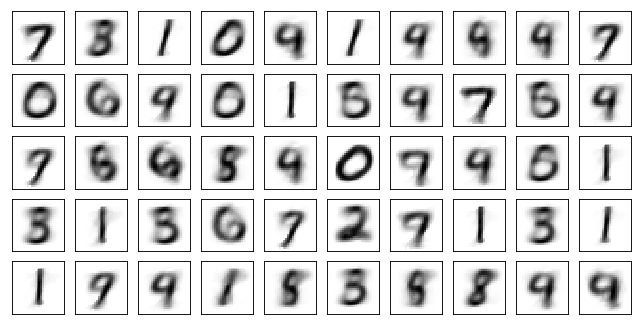

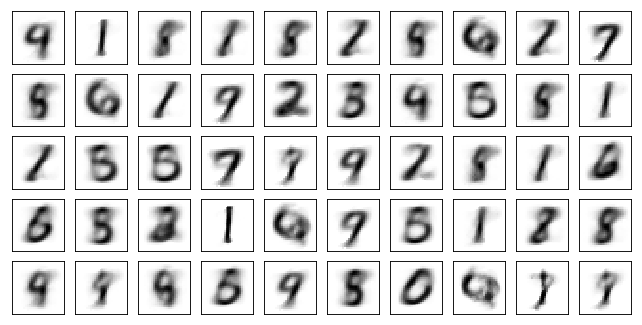

Test losses: VAE10: 0.1779/3.9755
Train Epoch: 7 [0/50000 (0%)]	Losses VAE10: 0.1659
Train Epoch: 7 [10000/50000 (20%)]	Losses VAE10: 0.1989
Train Epoch: 7 [20000/50000 (40%)]	Losses VAE10: 0.2080
Train Epoch: 7 [30000/50000 (60%)]	Losses VAE10: 0.1939
Train Epoch: 7 [40000/50000 (80%)]	Losses VAE10: 0.1863
Train Epoch: 7 [50000/50000 (100%)]	Losses VAE10: 0.1875


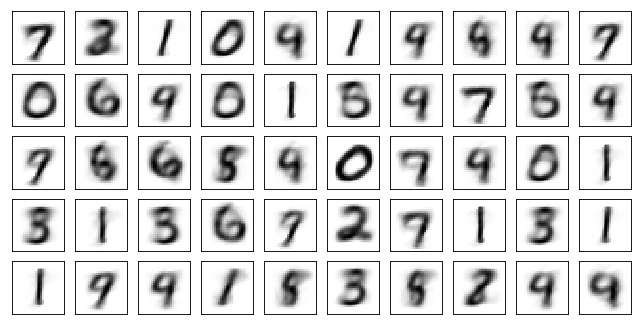

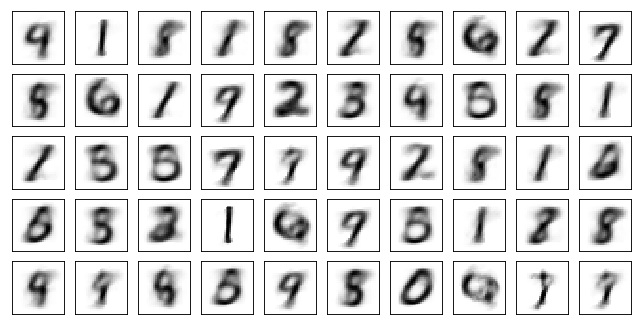

Test losses: VAE10: 0.1754/3.9033
Train Epoch: 8 [0/50000 (0%)]	Losses VAE10: 0.1685
Train Epoch: 8 [10000/50000 (20%)]	Losses VAE10: 0.1675
Train Epoch: 8 [20000/50000 (40%)]	Losses VAE10: 0.1696
Train Epoch: 8 [30000/50000 (60%)]	Losses VAE10: 0.1628
Train Epoch: 8 [40000/50000 (80%)]	Losses VAE10: 0.1785
Train Epoch: 8 [50000/50000 (100%)]	Losses VAE10: 0.2033


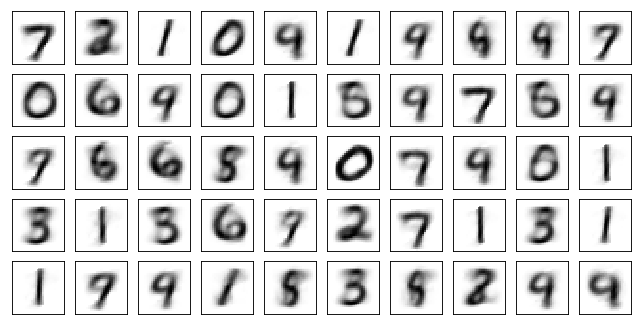

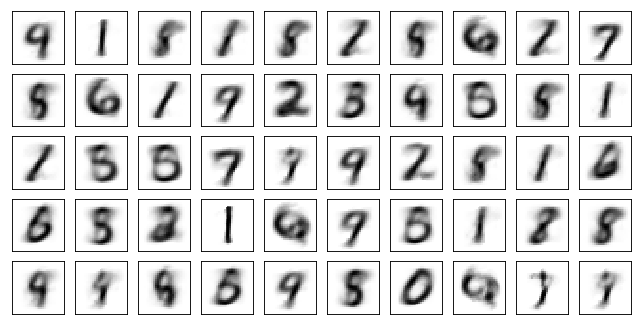

Test losses: VAE10: 0.1724/4.0968
Train Epoch: 9 [0/50000 (0%)]	Losses VAE10: 0.1778
Train Epoch: 9 [10000/50000 (20%)]	Losses VAE10: 0.1714
Train Epoch: 9 [20000/50000 (40%)]	Losses VAE10: 0.1792
Train Epoch: 9 [30000/50000 (60%)]	Losses VAE10: 0.1853
Train Epoch: 9 [40000/50000 (80%)]	Losses VAE10: 0.1718
Train Epoch: 9 [50000/50000 (100%)]	Losses VAE10: 0.1665


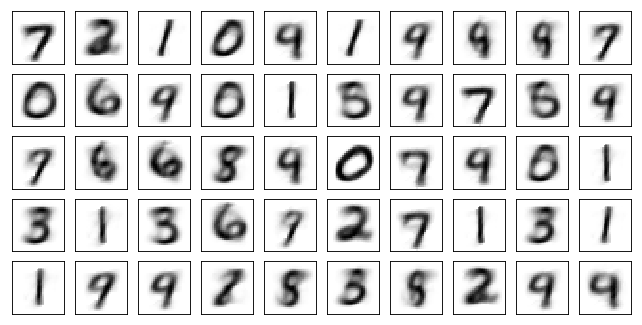

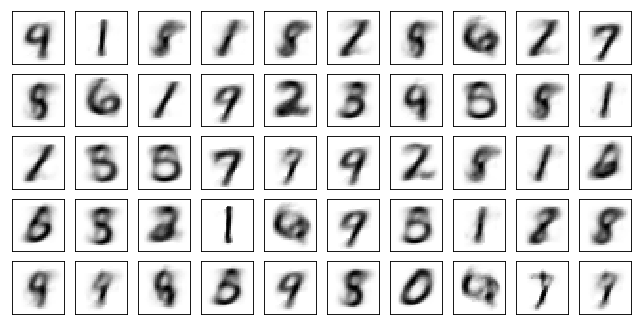

Test losses: VAE10: 0.1710/4.2609
Train Epoch: 10 [0/50000 (0%)]	Losses VAE10: 0.1891
Train Epoch: 10 [10000/50000 (20%)]	Losses VAE10: 0.1769
Train Epoch: 10 [20000/50000 (40%)]	Losses VAE10: 0.1742
Train Epoch: 10 [30000/50000 (60%)]	Losses VAE10: 0.1826
Train Epoch: 10 [40000/50000 (80%)]	Losses VAE10: 0.1878
Train Epoch: 10 [50000/50000 (100%)]	Losses VAE10: 0.1712


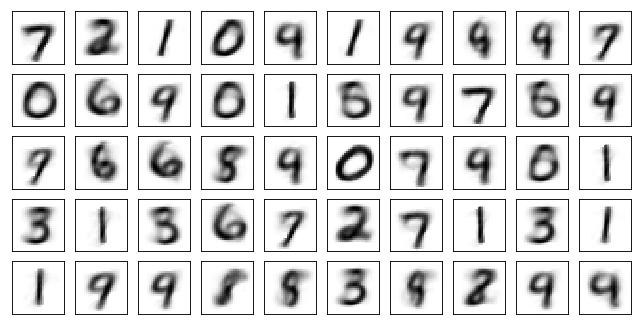

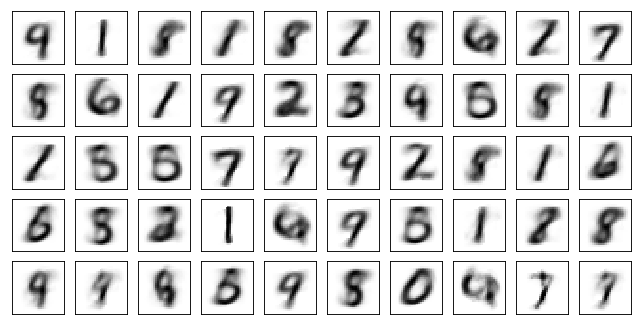

Test losses: VAE10: 0.1683/4.2418
Train Epoch: 11 [0/50000 (0%)]	Losses VAE10: 0.1528
Train Epoch: 11 [10000/50000 (20%)]	Losses VAE10: 0.1709
Train Epoch: 11 [20000/50000 (40%)]	Losses VAE10: 0.1744
Train Epoch: 11 [30000/50000 (60%)]	Losses VAE10: 0.1716
Train Epoch: 11 [40000/50000 (80%)]	Losses VAE10: 0.1695
Train Epoch: 11 [50000/50000 (100%)]	Losses VAE10: 0.1689


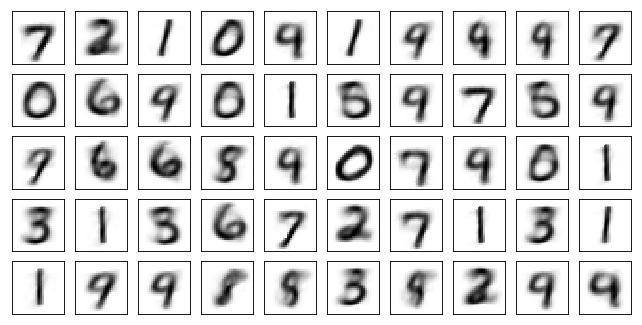

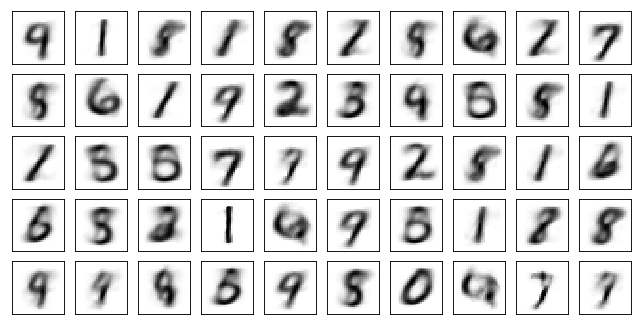

Test losses: VAE10: 0.1668/4.3309
Train Epoch: 12 [0/50000 (0%)]	Losses VAE10: 0.1674
Train Epoch: 12 [10000/50000 (20%)]	Losses VAE10: 0.1627
Train Epoch: 12 [20000/50000 (40%)]	Losses VAE10: 0.1666
Train Epoch: 12 [30000/50000 (60%)]	Losses VAE10: 0.1758
Train Epoch: 12 [40000/50000 (80%)]	Losses VAE10: 0.1866
Train Epoch: 12 [50000/50000 (100%)]	Losses VAE10: 0.1538


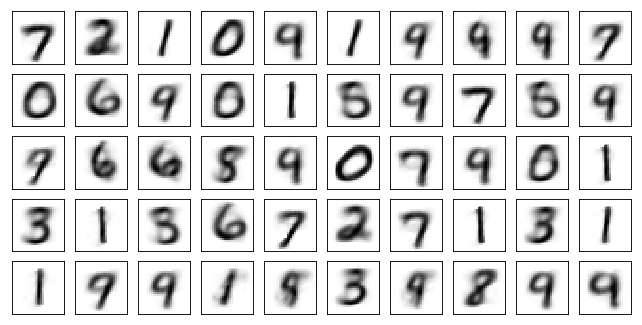

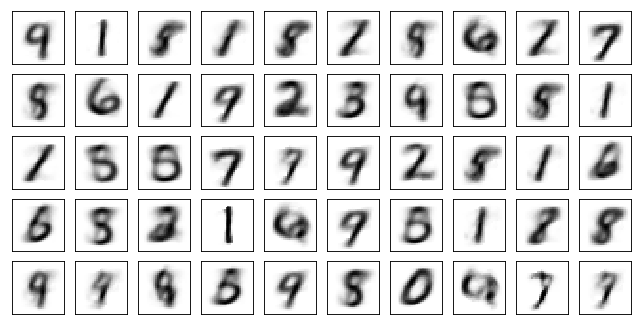

Test losses: VAE10: 0.1656/4.3113
Train Epoch: 13 [0/50000 (0%)]	Losses VAE10: 0.1599
Train Epoch: 13 [10000/50000 (20%)]	Losses VAE10: 0.1599
Train Epoch: 13 [20000/50000 (40%)]	Losses VAE10: 0.1625
Train Epoch: 13 [30000/50000 (60%)]	Losses VAE10: 0.1699
Train Epoch: 13 [40000/50000 (80%)]	Losses VAE10: 0.1619
Train Epoch: 13 [50000/50000 (100%)]	Losses VAE10: 0.1690


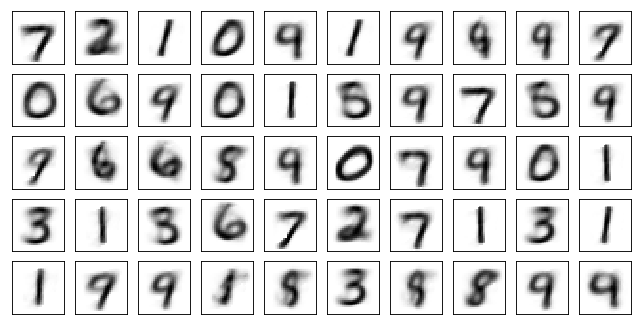

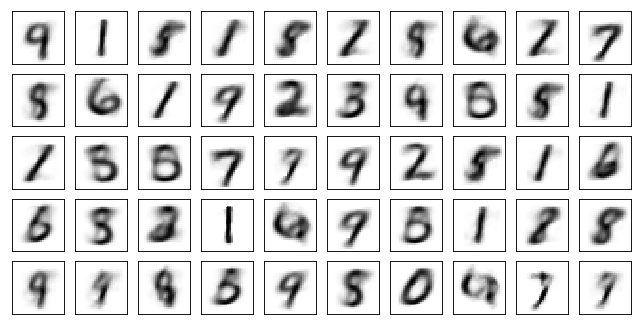

Test losses: VAE10: 0.1647/4.5155
Train Epoch: 14 [0/50000 (0%)]	Losses VAE10: 0.1670
Train Epoch: 14 [10000/50000 (20%)]	Losses VAE10: 0.1800
Train Epoch: 14 [20000/50000 (40%)]	Losses VAE10: 0.1828
Train Epoch: 14 [30000/50000 (60%)]	Losses VAE10: 0.1729
Train Epoch: 14 [40000/50000 (80%)]	Losses VAE10: 0.1497
Train Epoch: 14 [50000/50000 (100%)]	Losses VAE10: 0.1589


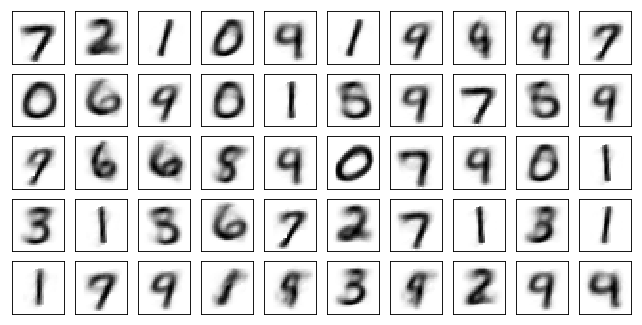

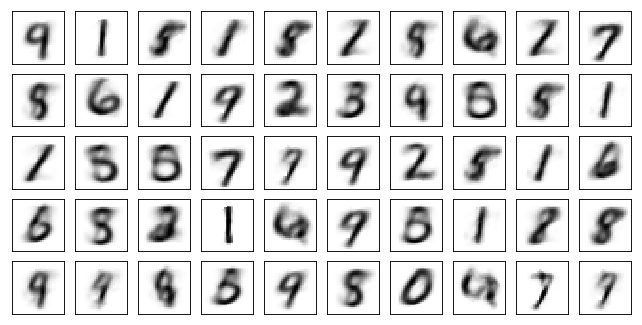

Test losses: VAE10: 0.1634/4.5829
Train Epoch: 15 [0/50000 (0%)]	Losses VAE10: 0.1779
Train Epoch: 15 [10000/50000 (20%)]	Losses VAE10: 0.1625
Train Epoch: 15 [20000/50000 (40%)]	Losses VAE10: 0.1498
Train Epoch: 15 [30000/50000 (60%)]	Losses VAE10: 0.1665
Train Epoch: 15 [40000/50000 (80%)]	Losses VAE10: 0.1626
Train Epoch: 15 [50000/50000 (100%)]	Losses VAE10: 0.1792


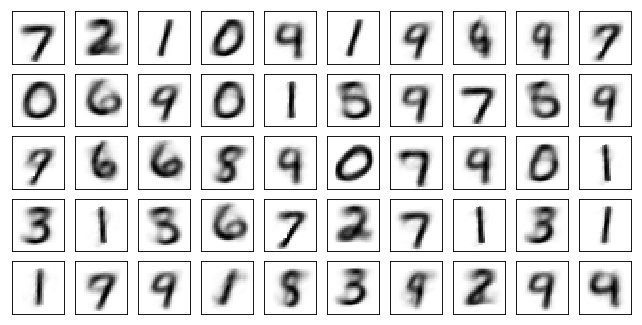

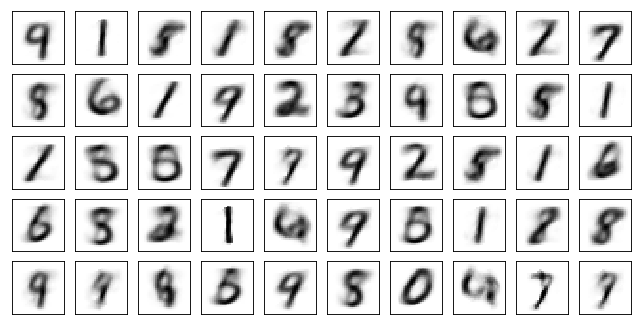

Test losses: VAE10: 0.1622/4.6069
Train Epoch: 16 [0/50000 (0%)]	Losses VAE10: 0.1623
Train Epoch: 16 [10000/50000 (20%)]	Losses VAE10: 0.1538
Train Epoch: 16 [20000/50000 (40%)]	Losses VAE10: 0.1751
Train Epoch: 16 [30000/50000 (60%)]	Losses VAE10: 0.1557
Train Epoch: 16 [40000/50000 (80%)]	Losses VAE10: 0.1715
Train Epoch: 16 [50000/50000 (100%)]	Losses VAE10: 0.1706


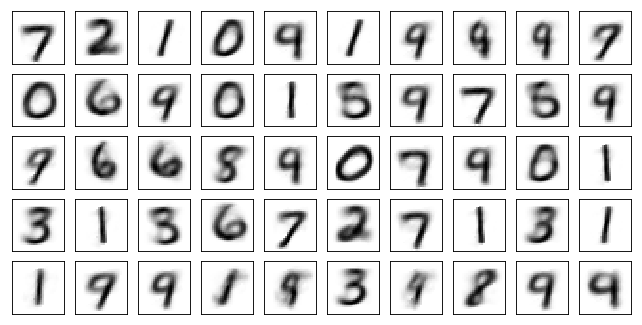

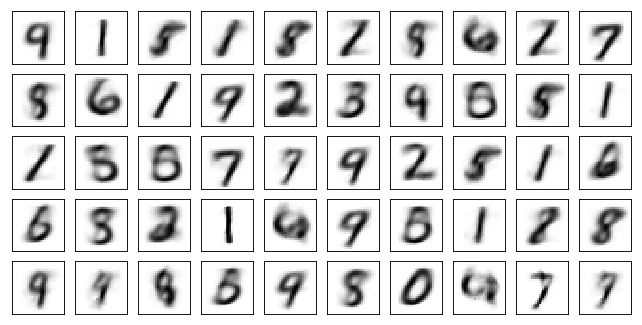

Test losses: VAE10: 0.1618/4.6086
Train Epoch: 17 [0/50000 (0%)]	Losses VAE10: 0.1767
Train Epoch: 17 [10000/50000 (20%)]	Losses VAE10: 0.1451
Train Epoch: 17 [20000/50000 (40%)]	Losses VAE10: 0.1773
Train Epoch: 17 [30000/50000 (60%)]	Losses VAE10: 0.1713
Train Epoch: 17 [40000/50000 (80%)]	Losses VAE10: 0.1751
Train Epoch: 17 [50000/50000 (100%)]	Losses VAE10: 0.1665


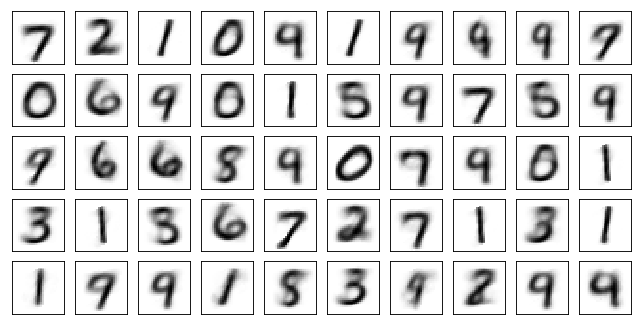

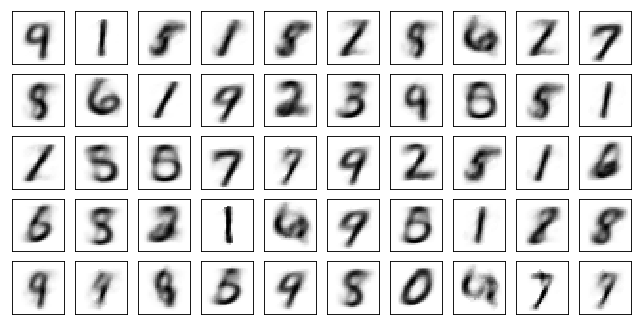

Test losses: VAE10: 0.1608/4.6177
Train Epoch: 18 [0/50000 (0%)]	Losses VAE10: 0.1487
Train Epoch: 18 [10000/50000 (20%)]	Losses VAE10: 0.1665
Train Epoch: 18 [20000/50000 (40%)]	Losses VAE10: 0.1407
Train Epoch: 18 [30000/50000 (60%)]	Losses VAE10: 0.1836
Train Epoch: 18 [40000/50000 (80%)]	Losses VAE10: 0.1648
Train Epoch: 18 [50000/50000 (100%)]	Losses VAE10: 0.1567


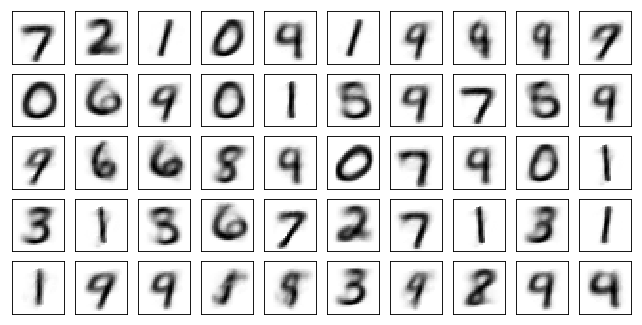

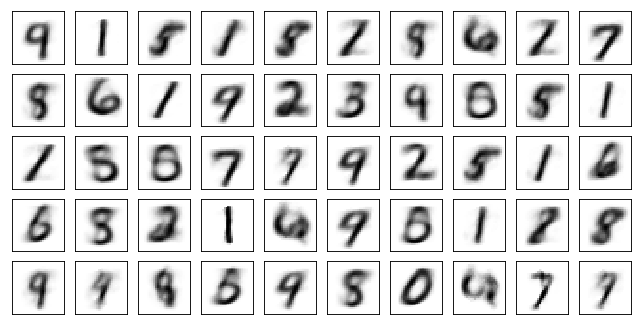

Test losses: VAE10: 0.1600/4.6728
Train Epoch: 19 [0/50000 (0%)]	Losses VAE10: 0.1743
Train Epoch: 19 [10000/50000 (20%)]	Losses VAE10: 0.1677
Train Epoch: 19 [20000/50000 (40%)]	Losses VAE10: 0.1665
Train Epoch: 19 [30000/50000 (60%)]	Losses VAE10: 0.1710
Train Epoch: 19 [40000/50000 (80%)]	Losses VAE10: 0.1512
Train Epoch: 19 [50000/50000 (100%)]	Losses VAE10: 0.1906


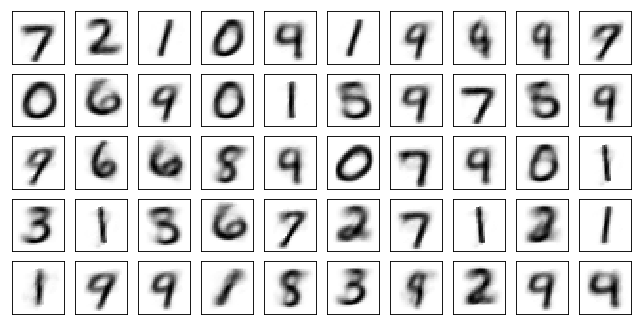

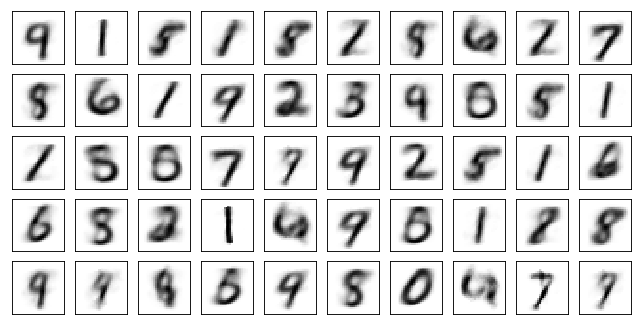

Test losses: VAE10: 0.1599/4.6011
Train Epoch: 20 [0/50000 (0%)]	Losses VAE10: 0.1636
Train Epoch: 20 [10000/50000 (20%)]	Losses VAE10: 0.1700
Train Epoch: 20 [20000/50000 (40%)]	Losses VAE10: 0.1553
Train Epoch: 20 [30000/50000 (60%)]	Losses VAE10: 0.1685
Train Epoch: 20 [40000/50000 (80%)]	Losses VAE10: 0.1831
Train Epoch: 20 [50000/50000 (100%)]	Losses VAE10: 0.1531


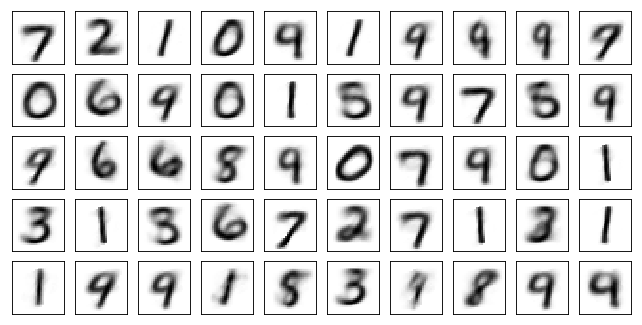

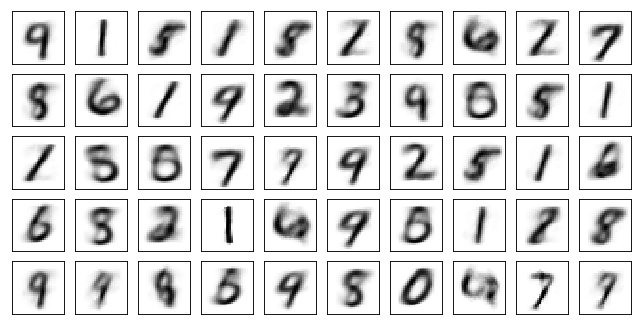

Test losses: VAE10: 0.1587/4.6808
Train Epoch: 21 [0/50000 (0%)]	Losses VAE10: 0.1658
Train Epoch: 21 [10000/50000 (20%)]	Losses VAE10: 0.1794
Train Epoch: 21 [20000/50000 (40%)]	Losses VAE10: 0.1719
Train Epoch: 21 [30000/50000 (60%)]	Losses VAE10: 0.1588
Train Epoch: 21 [40000/50000 (80%)]	Losses VAE10: 0.1418
Train Epoch: 21 [50000/50000 (100%)]	Losses VAE10: 0.1569


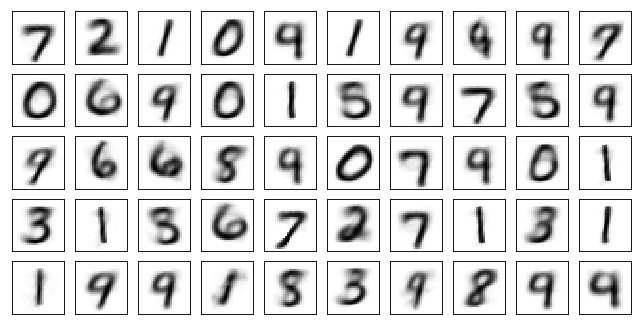

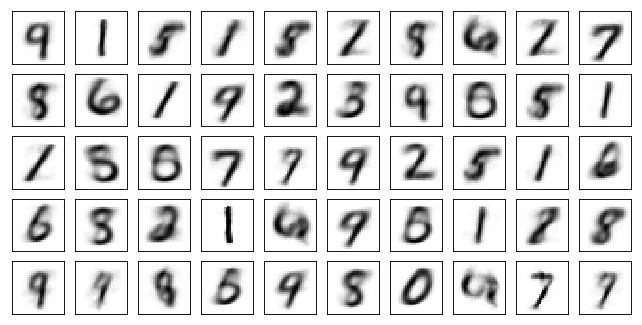

Test losses: VAE10: 0.1589/4.6594
Train Epoch: 22 [0/50000 (0%)]	Losses VAE10: 0.1602
Train Epoch: 22 [10000/50000 (20%)]	Losses VAE10: 0.1632
Train Epoch: 22 [20000/50000 (40%)]	Losses VAE10: 0.1434
Train Epoch: 22 [30000/50000 (60%)]	Losses VAE10: 0.1758
Train Epoch: 22 [40000/50000 (80%)]	Losses VAE10: 0.1507
Train Epoch: 22 [50000/50000 (100%)]	Losses VAE10: 0.1618


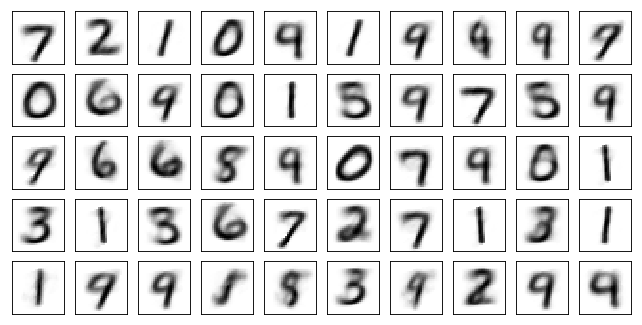

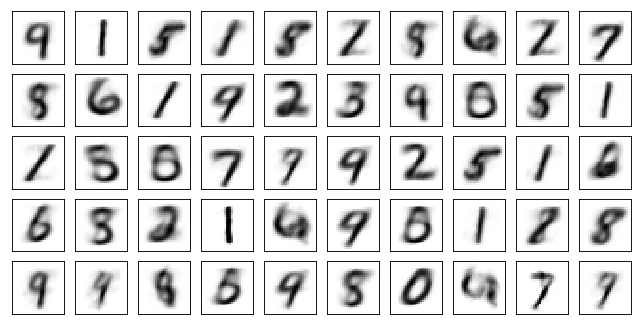

Test losses: VAE10: 0.1580/4.5952
Train Epoch: 23 [0/50000 (0%)]	Losses VAE10: 0.1700
Train Epoch: 23 [10000/50000 (20%)]	Losses VAE10: 0.1573
Train Epoch: 23 [20000/50000 (40%)]	Losses VAE10: 0.1730
Train Epoch: 23 [30000/50000 (60%)]	Losses VAE10: 0.1668
Train Epoch: 23 [40000/50000 (80%)]	Losses VAE10: 0.1397
Train Epoch: 23 [50000/50000 (100%)]	Losses VAE10: 0.1778


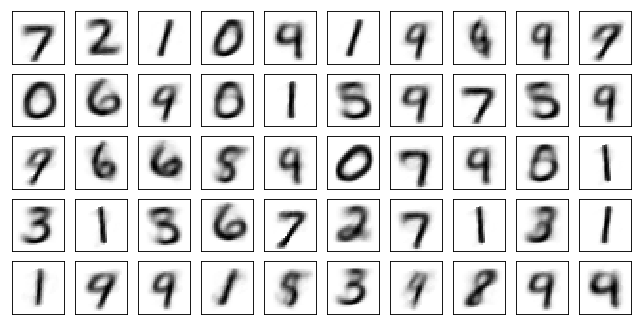

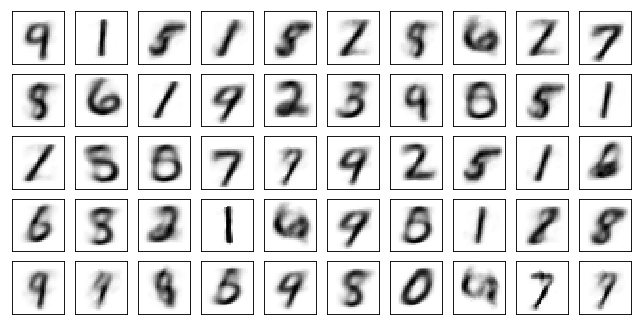

Test losses: VAE10: 0.1577/4.6255
Train Epoch: 24 [0/50000 (0%)]	Losses VAE10: 0.1575
Train Epoch: 24 [10000/50000 (20%)]	Losses VAE10: 0.1597
Train Epoch: 24 [20000/50000 (40%)]	Losses VAE10: 0.1748
Train Epoch: 24 [30000/50000 (60%)]	Losses VAE10: 0.1676
Train Epoch: 24 [40000/50000 (80%)]	Losses VAE10: 0.1599
Train Epoch: 24 [50000/50000 (100%)]	Losses VAE10: 0.1554


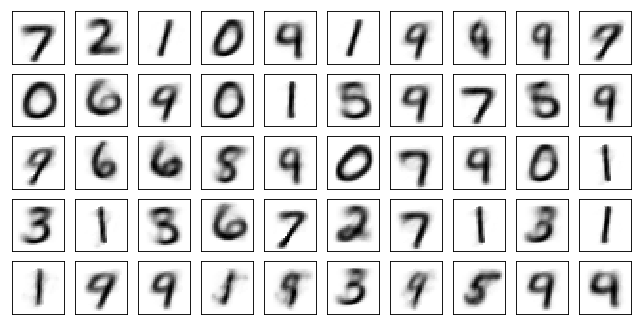

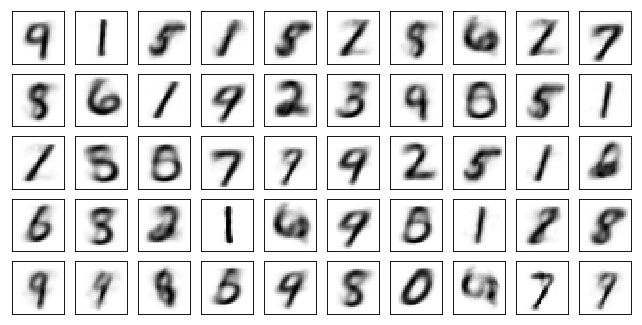

Test losses: VAE10: 0.1569/4.7127
Train Epoch: 25 [0/50000 (0%)]	Losses VAE10: 0.1642
Train Epoch: 25 [10000/50000 (20%)]	Losses VAE10: 0.1544
Train Epoch: 25 [20000/50000 (40%)]	Losses VAE10: 0.1460
Train Epoch: 25 [30000/50000 (60%)]	Losses VAE10: 0.1741
Train Epoch: 25 [40000/50000 (80%)]	Losses VAE10: 0.1676
Train Epoch: 25 [50000/50000 (100%)]	Losses VAE10: 0.1534


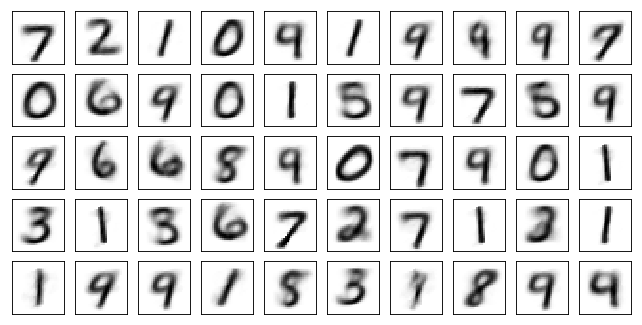

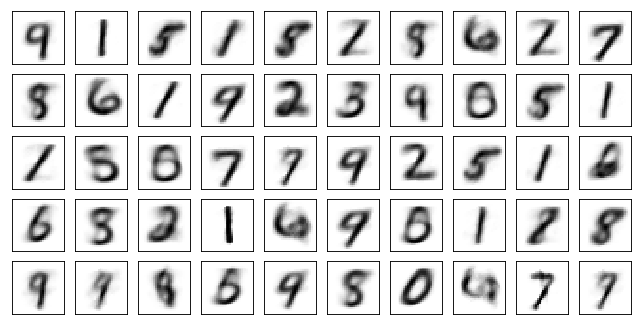

Test losses: VAE10: 0.1563/4.7408
Train Epoch: 26 [0/50000 (0%)]	Losses VAE10: 0.1768
Train Epoch: 26 [10000/50000 (20%)]	Losses VAE10: 0.1513
Train Epoch: 26 [20000/50000 (40%)]	Losses VAE10: 0.1598
Train Epoch: 26 [30000/50000 (60%)]	Losses VAE10: 0.1517
Train Epoch: 26 [40000/50000 (80%)]	Losses VAE10: 0.1607
Train Epoch: 26 [50000/50000 (100%)]	Losses VAE10: 0.1558


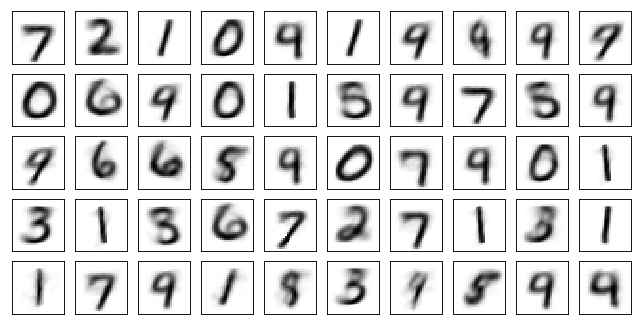

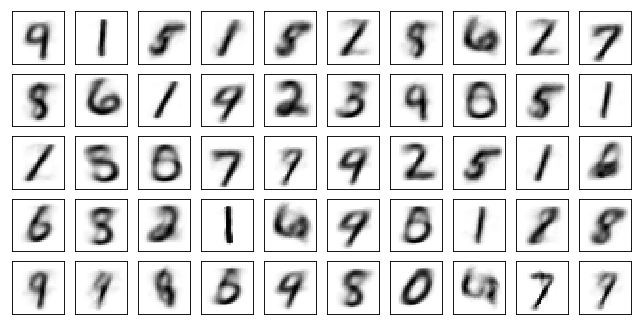

Test losses: VAE10: 0.1564/4.7137
Train Epoch: 27 [0/50000 (0%)]	Losses VAE10: 0.1782
Train Epoch: 27 [10000/50000 (20%)]	Losses VAE10: 0.1752
Train Epoch: 27 [20000/50000 (40%)]	Losses VAE10: 0.1642
Train Epoch: 27 [30000/50000 (60%)]	Losses VAE10: 0.1531
Train Epoch: 27 [40000/50000 (80%)]	Losses VAE10: 0.1765
Train Epoch: 27 [50000/50000 (100%)]	Losses VAE10: 0.1501


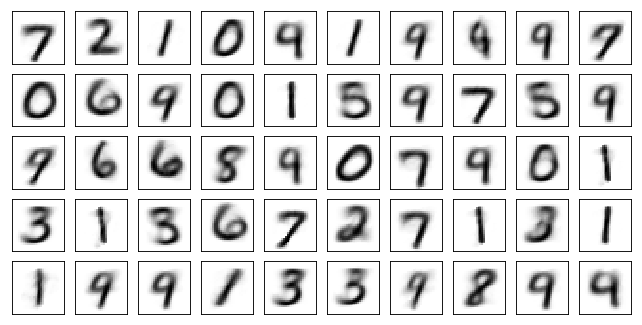

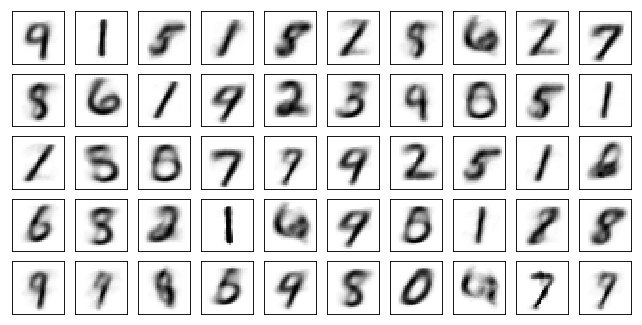

Test losses: VAE10: 0.1559/4.7600
Train Epoch: 28 [0/50000 (0%)]	Losses VAE10: 0.1821
Train Epoch: 28 [10000/50000 (20%)]	Losses VAE10: 0.1535
Train Epoch: 28 [20000/50000 (40%)]	Losses VAE10: 0.1439
Train Epoch: 28 [30000/50000 (60%)]	Losses VAE10: 0.1736
Train Epoch: 28 [40000/50000 (80%)]	Losses VAE10: 0.1536
Train Epoch: 28 [50000/50000 (100%)]	Losses VAE10: 0.1473


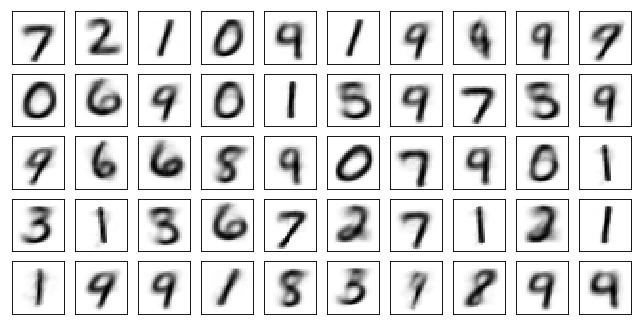

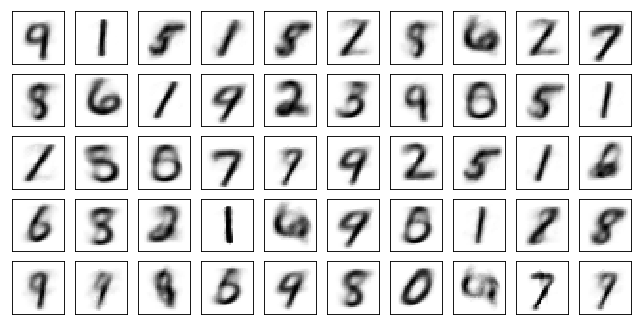

Test losses: VAE10: 0.1552/4.7543
Train Epoch: 29 [0/50000 (0%)]	Losses VAE10: 0.1595
Train Epoch: 29 [10000/50000 (20%)]	Losses VAE10: 0.1680
Train Epoch: 29 [20000/50000 (40%)]	Losses VAE10: 0.1625
Train Epoch: 29 [30000/50000 (60%)]	Losses VAE10: 0.1600
Train Epoch: 29 [40000/50000 (80%)]	Losses VAE10: 0.1549
Train Epoch: 29 [50000/50000 (100%)]	Losses VAE10: 0.1763


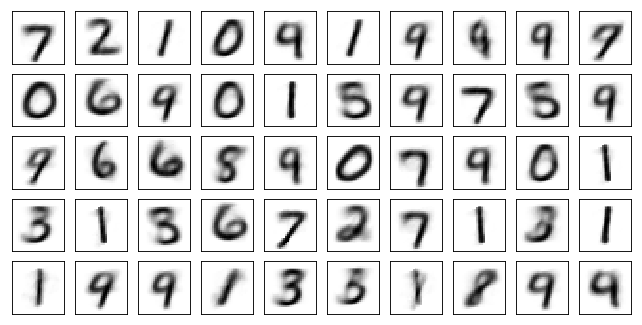

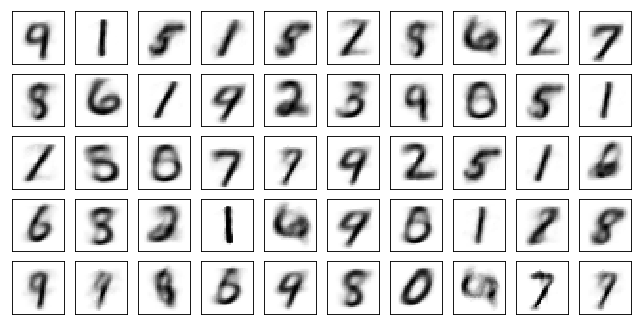

Test losses: VAE10: 0.1549/4.8608
Train Epoch: 30 [0/50000 (0%)]	Losses VAE10: 0.1581
Train Epoch: 30 [10000/50000 (20%)]	Losses VAE10: 0.1640
Train Epoch: 30 [20000/50000 (40%)]	Losses VAE10: 0.1374
Train Epoch: 30 [30000/50000 (60%)]	Losses VAE10: 0.1462
Train Epoch: 30 [40000/50000 (80%)]	Losses VAE10: 0.1684
Train Epoch: 30 [50000/50000 (100%)]	Losses VAE10: 0.1616


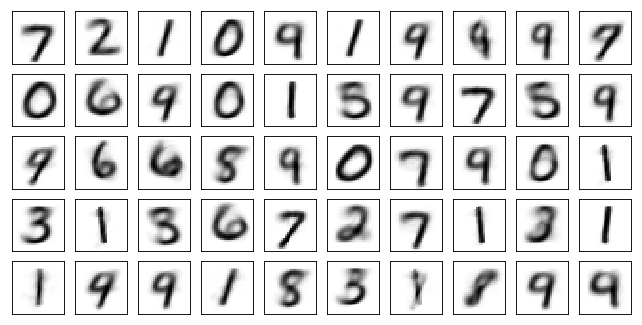

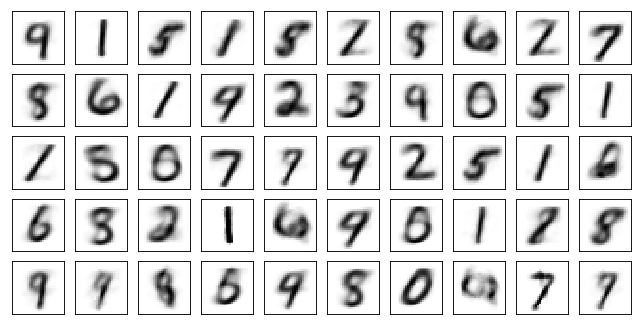

Test losses: VAE10: 0.1545/4.7837


In [23]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)

In [65]:
models

{'VAE10': Net(
   (fce): FullyConnected(
     (model): Sequential(
       (0): Linear(in_features=784, out_features=512, bias=True)
       (1): ReLU()
       (2): Linear(in_features=512, out_features=128, bias=True)
       (3): ReLU()
       (4): Linear(in_features=128, out_features=4, bias=True)
     )
   )
   (fcd): FullyConnected(
     (model): Sequential(
       (0): Linear(in_features=2, out_features=128, bias=True)
       (1): ReLU()
       (2): Linear(in_features=128, out_features=512, bias=True)
       (3): ReLU()
       (4): Linear(in_features=512, out_features=784, bias=True)
     )
   )
 )}

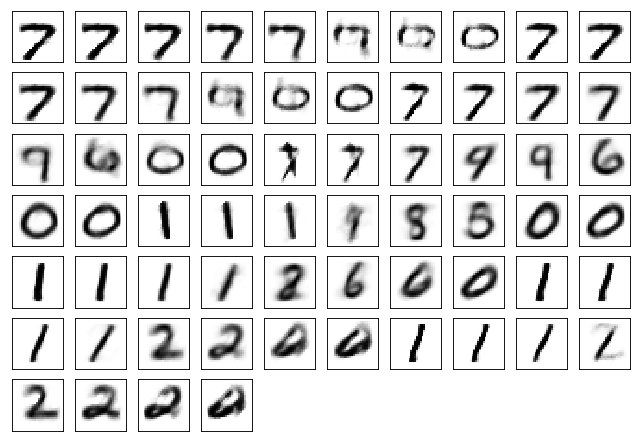

tensor([[-4., -4.],
        [-3., -4.],
        [-2., -4.],
        [-1., -4.],
        [ 0., -4.],
        [ 1., -4.],
        [ 2., -4.],
        [ 3., -4.],
        [-4., -3.],
        [-3., -3.],
        [-2., -3.],
        [-1., -3.],
        [ 0., -3.],
        [ 1., -3.],
        [ 2., -3.],
        [ 3., -3.],
        [-4., -2.],
        [-3., -2.],
        [-2., -2.],
        [-1., -2.],
        [ 0., -2.],
        [ 1., -2.],
        [ 2., -2.],
        [ 3., -2.],
        [-4., -1.],
        [-3., -1.],
        [-2., -1.],
        [-1., -1.],
        [ 0., -1.],
        [ 1., -1.],
        [ 2., -1.],
        [ 3., -1.],
        [-4.,  0.],
        [-3.,  0.],
        [-2.,  0.],
        [-1.,  0.],
        [ 0.,  0.],
        [ 1.,  0.],
        [ 2.,  0.],
        [ 3.,  0.],
        [-4.,  1.],
        [-3.,  1.],
        [-2.,  1.],
        [-1.,  1.],
        [ 0.,  1.],
        [ 1.,  1.],
        [ 2.,  1.],
        [ 3.,  1.],
        [-4.,  2.],
        [-3.,  2.],


In [97]:
x = np.arange(-4, 4, 1)
y = np.arange(-4, 4, 1)
X,Y = np.meshgrid(x,x)
XY=np.array([X.flatten(),Y.flatten()]).T
XY_tensor = torch.tensor(XY, dtype=torch.float)
with torch.no_grad():
  fixed_gen = models['VAE10'].decode(XY_tensor).data.numpy()
  plot_mnist(fixed_gen, (10, 10), True)
print(XY_tensor)

In [86]:
#print(h[49],h[48],h[4])
#print(fixed_data_t[1])

tensor([ 0.2800, -1.4552], grad_fn=<SelectBackward>) tensor([-0.2140, -1.3674], grad_fn=<SelectBackward>) tensor([-0.0804, -1.0436], grad_fn=<SelectBackward>)
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4])
